In [38]:
import argparse
import numpy as np
import pandas as pd
import torch
from tabulate import tabulate
from torch.utils.data import DataLoader

from model import BertCustomBinaryClassifier
from utils.ensemble_utils import make_predictions
from utils.evaluate_metrics import evaluate_metrics
from utils.data_preprocessing import load_dataset

In [39]:
import logging
logging.getLogger("transforkmer_values.modeling_utils").setLevel(logging.ERROR)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=64, help="")
parser.add_argument("--max_length", type=int, default=200, help="")
args = parser.parse_args(args=[])

# **BERT Models**

In [42]:
threshold = 0.50
kmer_values = [3, 4, 5, 6]
model_date = "2025-02-27_V2"

layer_1_results = []  # List to store results
layer_1_train_predictions_list, layer_1_test_predictions_list = [], []  # Lists for storing model predictions
layer_1_train_labels_list, layer_1_test_labels_list = [], []  # Lists for storing true labels

print(f"Threshold: {threshold}")
print(f"Identifier model date: {model_date}")

for kmer in kmer_values:

    args.model_path = f"./outputs/identifier_models/{model_date}/{kmer}-mer"
    args.test_data_path = f"./data/enhancer_identification/{kmer}-mer_identification_test.txt"
    args.train_data_path = f"./data/enhancer_identification/{kmer}-mer_identification_train.txt"

    # Load training and test datasets
    train_dataset = load_dataset(args, validation=False)
    test_dataset = load_dataset(args, validation=True)

    # Initialize data loaders for batch processing
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    # Model
    model = BertCustomBinaryClassifier.from_pretrained(args.model_path, num_labels=1).to(device)

    # Prediction on training datasets
    layer_1_train_predictions, layer_1_train_labels = make_predictions(model, train_dataloader, kmer=kmer)
    layer_1_train_predictions_list.append(layer_1_train_predictions)
    layer_1_train_labels_list.append(layer_1_train_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(layer_1_train_predictions, layer_1_train_labels)
    layer_1_results.append({"k-mer": kmer, "Dataset": "Train", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

    # Prediction on test (independent) dataset
    layer_1_test_predictions, layer_1_test_labels = make_predictions(model, test_dataloader, kmer=kmer)
    layer_1_test_predictions_list.append(layer_1_test_predictions)
    layer_1_test_labels_list.append(layer_1_test_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(layer_1_test_predictions, layer_1_test_labels)
    layer_1_results.append({"k-mer": kmer, "Dataset": "Test", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

Threshold: 0.5
Identifier model date: 2025-02-27_V2


In [43]:
threshold = 0.50
kmer_values = [3, 4, 5, 6]
model_date = "2025-02-27_V2"

layer_2_results = []  # List to store results
layer_2_train_predictions_list, layer_2_test_predictions_list = [], []  # Lists for storing model predictions
layer_2_train_labels_list, layer_2_test_labels_list = [], []  # Lists for storing true labels

print(f"Threshold: {threshold}")
print(f"Classifier model date: {model_date}")

for kmer in kmer_values:

    args.model_path = f"./outputs/classifier_models/{model_date}/{kmer}-mer"
    args.test_data_path = f"./data/enhancer_classification/{kmer}-mer_classification_test.txt"
    args.train_data_path = f"./data/enhancer_classification/{kmer}-mer_classification_train.txt"

    # Load training and test datasets
    train_dataset = load_dataset(args, validation=False)
    test_dataset = load_dataset(args, validation=True)

    # Initialize data loaders for batch processing
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    # Model
    model = BertCustomBinaryClassifier.from_pretrained(args.model_path, num_labels=1).to(device)

    # Prediction on training datasets
    layer_2_train_predictions, layer_2_train_labels = make_predictions(model, train_dataloader, kmer=kmer)
    layer_2_train_predictions_list.append(layer_2_train_predictions)
    layer_2_train_labels_list.append(layer_2_train_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(layer_2_train_predictions, layer_2_train_labels)
    layer_2_results.append({"k-mer": kmer, "Dataset": "Train", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

    # Prediction on test (independent) dataset
    layer_2_test_predictions, layer_2_test_labels = make_predictions(model, test_dataloader, kmer=kmer)
    layer_2_test_predictions_list.append(layer_2_test_predictions)
    layer_2_test_labels_list.append(layer_2_test_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(layer_2_test_predictions, layer_2_test_labels)
    layer_2_results.append({"k-mer": kmer, "Dataset": "Test", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

Threshold: 0.5
Classifier model date: 2025-02-27_V2


In [44]:
from sklearn.ensemble import  ExtraTreesClassifier

In [45]:
# Prepare meta-features for training and testing
layer_1_train_meta_features = np.column_stack(layer_1_train_predictions_list)
layer_1_test_meta_features = np.column_stack(layer_1_test_predictions_list)

layer_1_train_labels = layer_1_train_labels_list[0]     
layer_1_test_labels = layer_1_test_labels_list[0]

In [46]:
# Prepare meta-features for training and testing
layer_2_train_meta_features = np.column_stack(layer_2_train_predictions_list)
layer_2_test_meta_features = np.column_stack(layer_2_test_predictions_list)

layer_2_train_labels = layer_2_train_labels_list[0]     
layer_2_test_labels = layer_2_test_labels_list[0]

In [47]:
layer_1_model = ExtraTreesClassifier(n_estimators=1000, random_state=42)

threshold_et = 0.88   

# Train the Stacking Classifier on the training set
layer_1_model.fit(layer_1_train_meta_features, layer_1_train_labels)

# Meta-model predictions on the validation set
layer_1_train_predictions_et = layer_1_model.predict_proba(layer_1_train_meta_features)[:, 1]
layer_1_test_predictions_et = layer_1_model.predict_proba(layer_1_test_meta_features)[:, 1]

train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(layer_1_train_predictions_et, layer_1_train_labels, threshold=threshold_et)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(layer_1_test_predictions_et, layer_1_test_labels, threshold=threshold_et)

# Display results in table using tabulate
layer_1_results = [["Train", train_acc, train_sn, train_sp, train_mcc, train_auc], ["Test", test_acc, test_sn, test_sp, test_mcc, test_auc]]

layer_1_headers = ["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"]

print(tabulate(layer_1_results, headers=layer_1_headers, tablefmt="grid", floatfmt=".4f"))

+-----------+------------+---------------+---------------+--------+--------+
| Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===========+============+===============+===============+========+========+
| Train     |     1.0000 |        1.0000 |        1.0000 | 1.0000 | 1.0000 |
+-----------+------------+---------------+---------------+--------+--------+
| Test      |     0.8350 |        0.7500 |        0.9200 | 0.6799 | 0.8652 |
+-----------+------------+---------------+---------------+--------+--------+


In [48]:
layer_2_model = ExtraTreesClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

threshold_et = 0.9999   

# Train the Stacking Classifier on the training set
layer_2_model.fit(layer_2_train_meta_features, layer_2_train_labels)

# Meta-model predictions on the validation set
layer_2_train_predictions_et = layer_2_model.predict_proba(layer_2_train_meta_features)[:, 1]
layer_2_test_predictions_et = layer_2_model.predict_proba(layer_2_test_meta_features)[:, 1]

train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(layer_2_train_predictions_et, layer_2_train_labels, threshold=threshold_et)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(layer_2_test_predictions_et, layer_2_test_labels, threshold=threshold_et)

# Display results in table using tabulate
results = [["Train", train_acc, train_sn, train_sp, train_mcc, train_auc], ["Test", test_acc, test_sn, test_sp, test_mcc, test_auc]]

headers = ["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"]

print(tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f"))

+-----------+------------+---------------+---------------+--------+--------+
| Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===========+============+===============+===============+========+========+
| Train     |     1.0000 |        1.0000 |        1.0000 | 1.0000 | 1.0000 |
+-----------+------------+---------------+---------------+--------+--------+
| Test      |     0.9900 |        1.0000 |        0.9800 | 0.9802 | 0.9900 |
+-----------+------------+---------------+---------------+--------+--------+


In [49]:
layer_1_train_predictions = layer_1_train_predictions_et
layer_1_test_predictions = layer_1_test_predictions_et

In [50]:
layer_2_train_predictions = layer_2_train_predictions_et
layer_2_test_predictions = layer_2_test_predictions_et

# **Plots**

## **ROC Curve**

In [51]:
import matplotlib.pyplot as plt

output_folder = "outputs/plots"

In [52]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

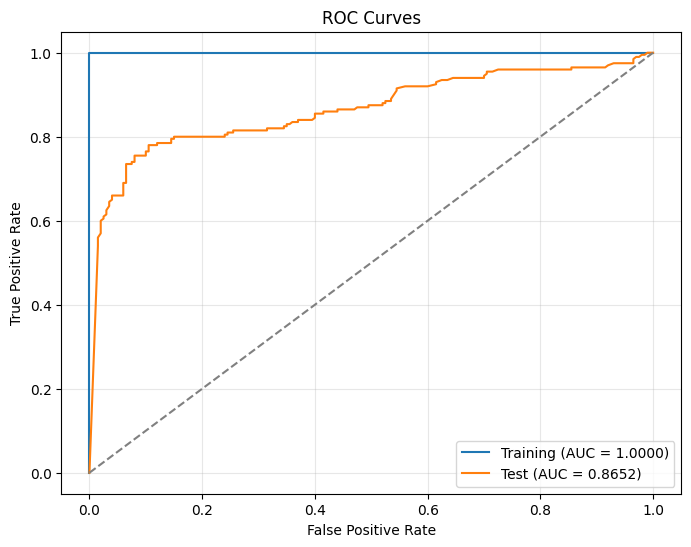

In [62]:
# Function to plot ROC curve
def plot_single_roc_curve(predictions, labels, dataset_name):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{dataset_name} (AUC = {roc_auc:.4f})")


# Plot ROC curves for training and testing datasets
plt.figure(figsize=(8, 6))

# Training ROC Curve
plot_single_roc_curve(layer_1_train_predictions, layer_1_train_labels, "Training")

# Testing ROC Curve
plot_single_roc_curve(layer_1_test_predictions, layer_1_test_labels, "Test")

# Plot settings
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for random guessing
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

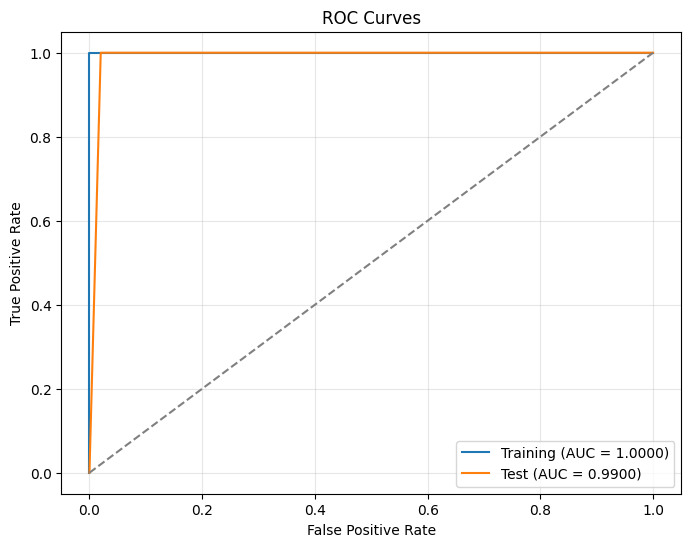

In [54]:
# Plot ROC curves for training and testing datasets
plt.figure(figsize=(8, 6))

# Training ROC Curve
plot_single_roc_curve(layer_2_train_predictions, layer_2_train_labels, "Training")

# Testing ROC Curve
plot_single_roc_curve(layer_2_test_predictions, layer_2_test_labels, "Test")

# Plot settings
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for random guessing
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

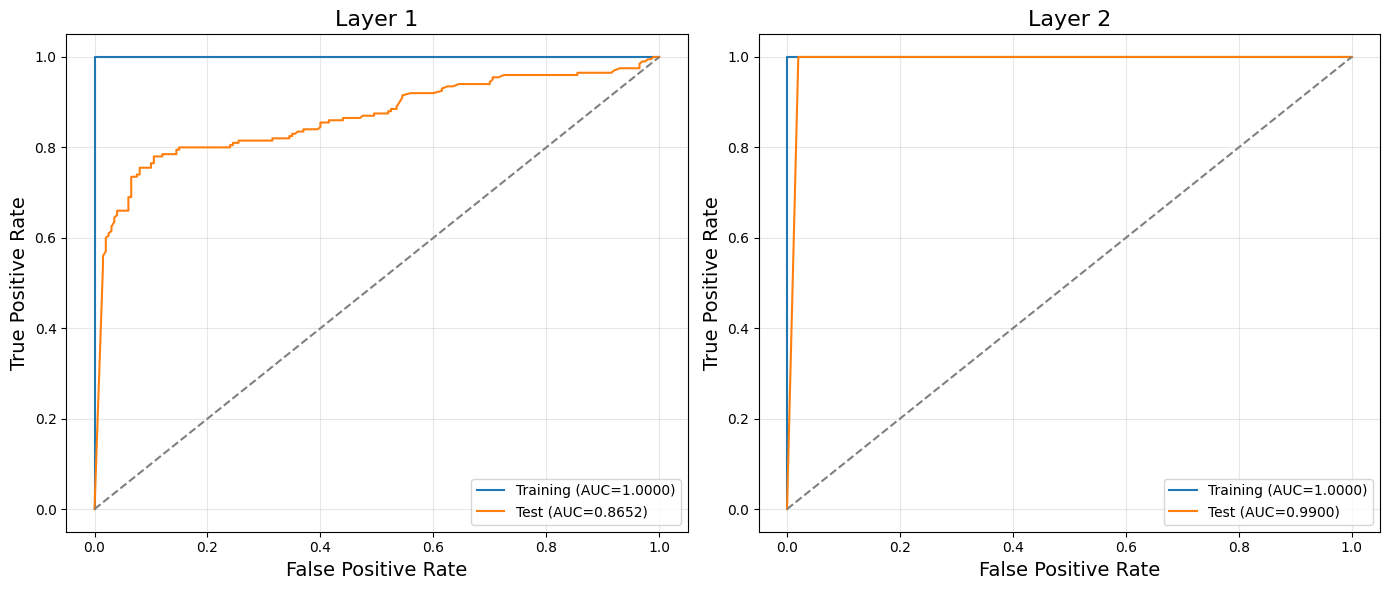

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(ax, train_predictions, train_labels, test_predictions, test_labels, layer_name):
    # Training ROC
    fpr_train, tpr_train, _ = roc_curve(train_labels, train_predictions)
    auc_train = auc(fpr_train, tpr_train)
    ax.plot(fpr_train, tpr_train, label=f"Training (AUC={auc_train:.4f})")
    
    # Test ROC
    fpr_test, tpr_test, _ = roc_curve(test_labels, test_predictions)
    auc_test = auc(fpr_test, tpr_test)
    ax.plot(fpr_test, tpr_test, label=f"Test (AUC={auc_test:.4f})")
    
    # Diagonal line
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    ax.set_xlabel("False Positive Rate", fontsize=14)
    ax.set_ylabel("True Positive Rate", fontsize=14)
    ax.set_title(f"{layer_name}", fontsize=16)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Layer 1 ROC curves
plot_roc_curves(
    ax1,
    layer_1_train_predictions, layer_1_train_labels,
    layer_1_test_predictions, layer_1_test_labels,
    "Layer 1"
)

# Layer 2 ROC curves
plot_roc_curves(
    ax2,
    layer_2_train_predictions, layer_2_train_labels,
    layer_2_test_predictions, layer_2_test_labels,
    "Layer 2"
)

plt.tight_layout()

plt.savefig(f"{output_folder}/layer_1_2_roc_curves.pdf", format="pdf", bbox_inches='tight')
plt.show()


## **Precision-Recall Curve**

In [55]:
# Calculate precision and recall for training data
layer_1_precision_train, layer_1_recall_train, _ = precision_recall_curve(layer_1_train_labels, layer_1_train_predictions)
layer_1_average_precision_train = average_precision_score(layer_1_train_labels, layer_1_train_predictions)

# Calculate precision and recall for test data
layer_1_precision_test, layer_1_recall_test, _ = precision_recall_curve(layer_1_test_labels, layer_1_test_predictions)
layer_1_average_precision_test = average_precision_score(layer_1_test_labels, layer_1_test_predictions)

In [56]:
# Calculate precision and recall for training data
layer_2_precision_train, layer_2_recall_train, _ = precision_recall_curve(layer_2_train_labels, layer_2_train_predictions)
layer_2_average_precision_train = average_precision_score(layer_2_train_labels, layer_2_train_predictions)

# Calculate precision and recall for test data
layer_2_precision_test, layer_2_recall_test, _ = precision_recall_curve(layer_2_test_labels, layer_2_test_predictions)
layer_2_average_precision_test = average_precision_score(layer_2_test_labels, layer_2_test_predictions)

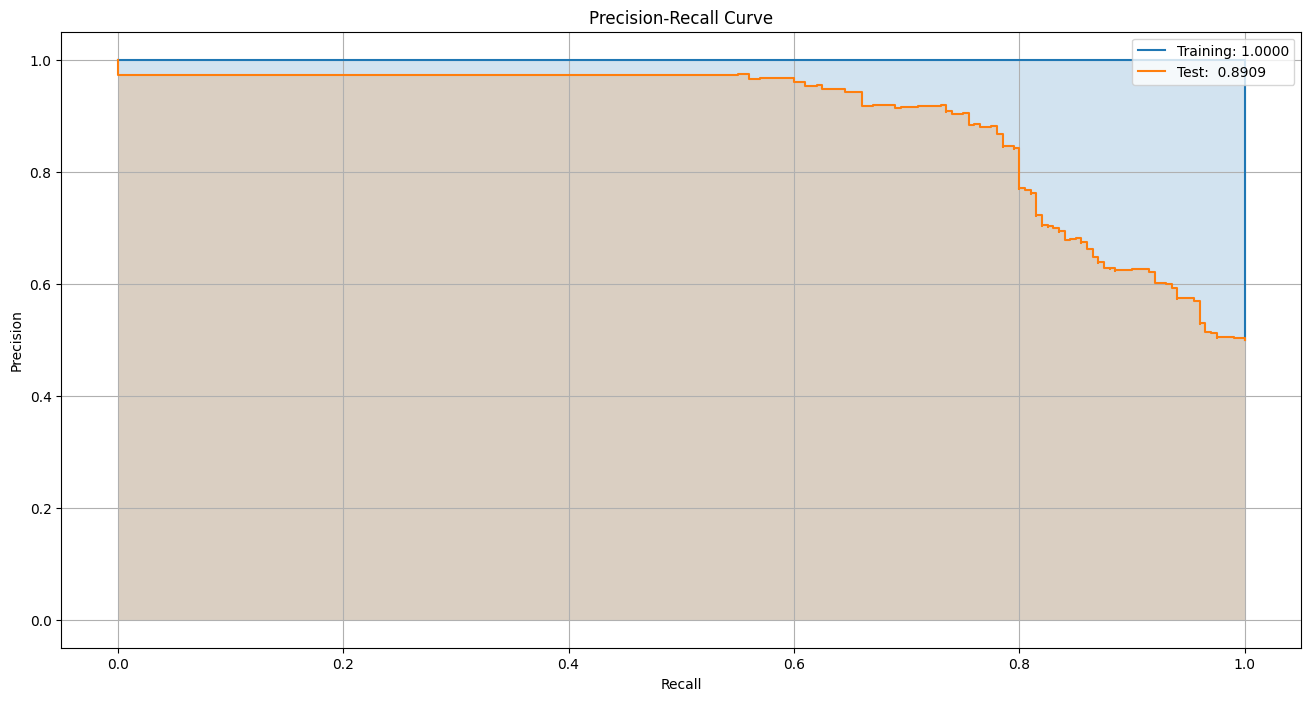

In [57]:
# Plotting the PR curves
plt.figure(figsize=(16, 8))

# Training PR curve
plt.step(layer_1_recall_train, layer_1_precision_train, where="post", label=f"Training: {layer_1_average_precision_train:.4f}")
plt.fill_between(layer_1_recall_train, layer_1_precision_train, step="post", alpha=0.2)

# Test PR curve
plt.step(layer_1_recall_test, layer_1_precision_test, where="post", label=f"Test:  {layer_1_average_precision_test:.4f}")
plt.fill_between(layer_1_recall_test, layer_1_precision_test, step="post", alpha=0.2)

# Plot settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

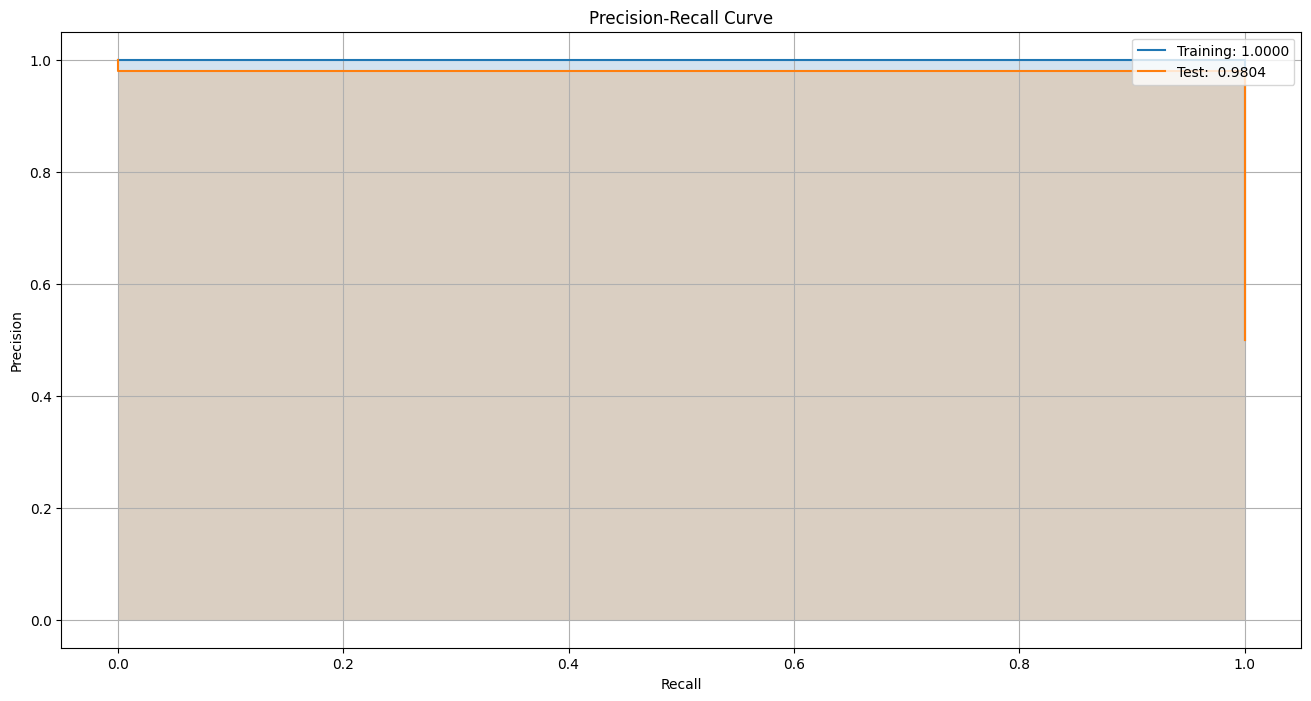

In [58]:
# Plotting the PR curves
plt.figure(figsize=(16, 8))

# Training PR curve
plt.step(layer_2_recall_train, layer_2_precision_train, where="post", label=f"Training: {layer_2_average_precision_train:.4f}")
plt.fill_between(layer_2_recall_train, layer_2_precision_train, step="post", alpha=0.2)

# Test PR curve
plt.step(layer_2_recall_test, layer_2_precision_test, where="post", label=f"Test:  {layer_2_average_precision_test:.4f}")
plt.fill_between(layer_2_recall_test, layer_2_precision_test, step="post", alpha=0.2)

# Plot settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

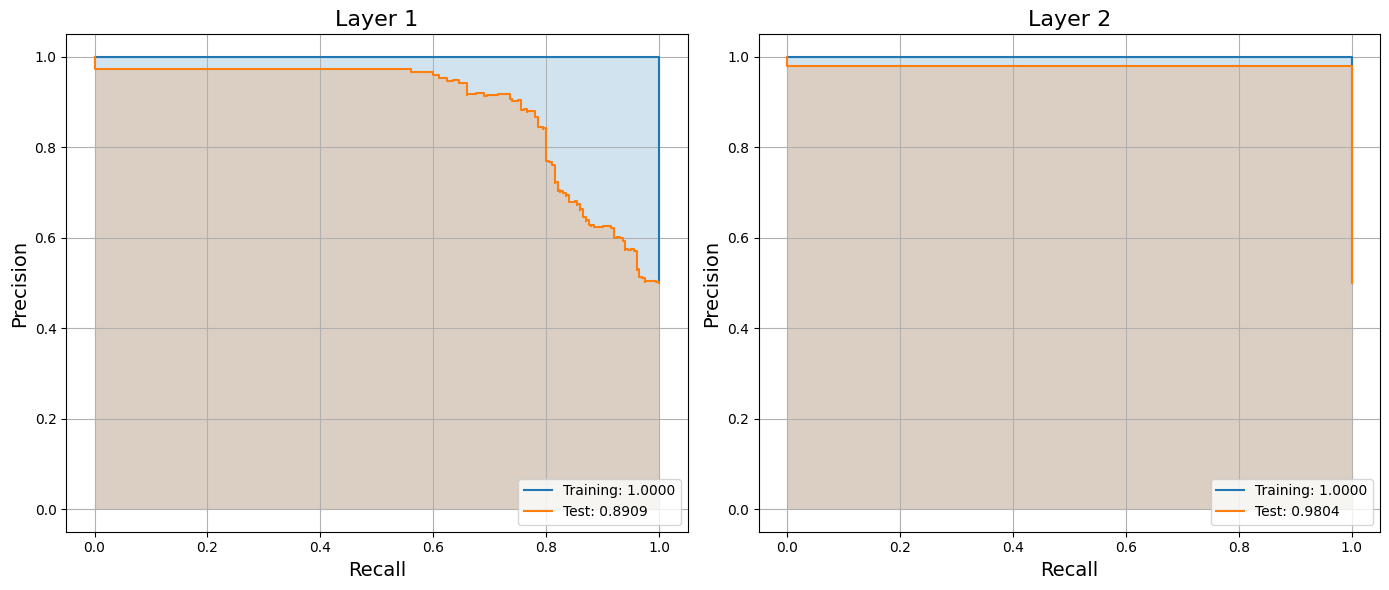

In [88]:
plt.figure(figsize=(14, 6))

# First subplot for layer 1
plt.subplot(1, 2, 1)
plt.step(layer_1_recall_train, layer_1_precision_train, where="post", label=f"Training: {layer_1_average_precision_train:.4f}")
plt.fill_between(layer_1_recall_train, layer_1_precision_train, step="post", alpha=0.2)
plt.step(layer_1_recall_test, layer_1_precision_test, where="post", label=f"Test: {layer_1_average_precision_test:.4f}")
plt.fill_between(layer_1_recall_test, layer_1_precision_test, step="post", alpha=0.2)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Layer 1", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)

# Second subplot for layer 2
plt.subplot(1, 2, 2)
plt.step(layer_2_recall_train, layer_2_precision_train, where="post", label=f"Training: {layer_2_average_precision_train:.4f}")
plt.fill_between(layer_2_recall_train, layer_2_precision_train, step="post", alpha=0.2)
plt.step(layer_2_recall_test, layer_2_precision_test, where="post", label=f"Test: {layer_2_average_precision_test:.4f}")
plt.fill_between(layer_2_recall_test, layer_2_precision_test, step="post", alpha=0.2)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Layer 2", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{output_folder}/layer_1_2_pr_curves.pdf", format="pdf", bbox_inches='tight')

plt.show()
